# CNN + Lemmatization

# Introduction
In this notebook, we use the same model from CNN.ipynb but with lemmatization method for data preprocessing step. Lemmatization cleans the original test data by reducing words in the dataset into the original form, which often helps the model to extract features from datasets.

In [3]:
from datasets import load_dataset
import random
import string
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [8]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/deyuq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/deyuq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
emotions = load_dataset("dair-ai/emotion")

In [10]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [28]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

# Lemmatization
Define function for applying lemmatization to training data.

In [29]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [31]:
lemmatized_train_data = []
lemmatized_val_data = []
lemmatized_test_data = []
for sentence in train_data["text"]:
    lemmatized_train_data.append(cleaning(sentence))
for sentence in validation_data["text"]:
    lemmatized_val_data.append(cleaning(sentence))
for sentence in test_data["text"]:
    lemmatized_test_data.append(cleaning(sentence))

In [38]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [39]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: list, labels: list, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data, labels):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [40]:
train_instances = preprocess(lemmatized_train_data, train_data["label"], tokenizer)
val_instances = preprocess(lemmatized_val_data, validation_data["label"], tokenizer)
test_instances = preprocess(lemmatized_test_data, test_data["label"], tokenizer)

In [42]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [43]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        self.val_score = []
        self.train_losses = []
        self.val_losses = []

        for epoch in range(epochs):
            train_batches = batching(train_instances, batch_size=batch_size, shuffle=True)
            epoch_train_loss = 0.0
            total_train_samples = 0

            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
                total_train_samples += inputs.size(0)

            avg_train_loss = epoch_train_loss / total_train_samples
            self.train_losses.append(avg_train_loss)

            # Evaluate on validation set
            self.eval()
            val_batches = batching(val_instances, batch_size=batch_size, shuffle=False)
            epoch_val_loss = 0.0
            total_val_samples = 0

            with torch.no_grad():
                for inputs, labels in val_batches:
                    outputs = self(inputs)
                    loss = nn.functional.cross_entropy(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                    total_val_samples += inputs.size(0)

            avg_val_loss = epoch_val_loss / total_val_samples
            self.val_losses.append(avg_val_loss)

            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)
            self.val_score.append(val_f1)

            print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
                  f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")
    
    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [44]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=5, batch_size=16)

100%|██████████| 1000/1000 [00:04<00:00, 246.48it/s]


Epoch 1 | Train Loss: 0.9963 | Val Loss: 0.4386 | Train F1: 0.8452 | Val F1: 0.7876


100%|██████████| 1000/1000 [00:04<00:00, 244.06it/s]


Epoch 2 | Train Loss: 0.2718 | Val Loss: 0.3351 | Train F1: 0.9378 | Val F1: 0.8482


100%|██████████| 1000/1000 [00:04<00:00, 237.42it/s]


Epoch 3 | Train Loss: 0.1193 | Val Loss: 0.3373 | Train F1: 0.9739 | Val F1: 0.8456


100%|██████████| 1000/1000 [00:04<00:00, 238.71it/s]


Epoch 4 | Train Loss: 0.0704 | Val Loss: 0.3813 | Train F1: 0.9781 | Val F1: 0.8393


100%|██████████| 1000/1000 [00:04<00:00, 237.49it/s]


Epoch 5 | Train Loss: 0.0534 | Val Loss: 0.4793 | Train F1: 0.9799 | Val F1: 0.8356


In [45]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.8675
Precision: 0.8095429737045318
Recall: 0.8213258506836061
F1 Score: 0.8136135768933418
Confusion Matrix:
[[499  19   4  36  22   1]
 [  3 631  37  11   7   6]
 [  3  33 112   7   4   0]
 [  9   5   2 246  11   2]
 [  5   1   0   3 204  11]
 [  1   6   0   0  16  43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       581
           1       0.91      0.91      0.91       695
           2       0.72      0.70      0.71       159
           3       0.81      0.89      0.85       275
           4       0.77      0.91      0.84       224
           5       0.68      0.65      0.67        66

    accuracy                           0.87      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.87      0.87      0.87      2000



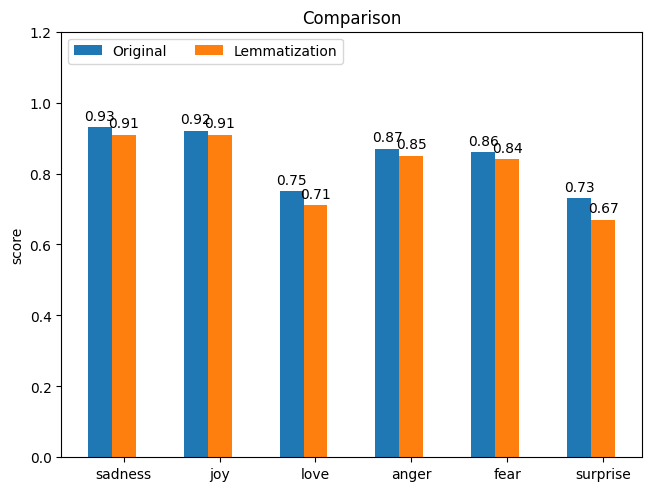

In [ ]:
performance = {
    'Original': (0.93, 0.92, 0.75, 0.87, 0.86, 0.73),
    'Lemmatization': (0.91, 0.91, 0.71, 0.85, 0.84, 0.67)
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Comparison')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

# Result&Conclusion
From the classification report above, we can see that the lemmatization does not help CNN in learning training data since the performance does not improve. Comparing to 89% of accuracy from original CNN, it is now 87% after lemmatization; 2% lower in accuracy does not means diminishing performance as it is not huge, but it is definitely not an improvement. It also does not help for individual classes when we compare the f1-scores with the original model.   
Why lemmatization does not help our model? We think there are two reasons. First, it is because of our dataset. As the publisher of the dataset says, the dataset is already cleaned, which means they have pre-processed the dataset. Second, our tokenizer and model is complex enough that lemmatization is no need. Our BPE tokenizer is a pre-trained tokenizer, and it is widely used for many SOTA models, which proves its performance. This tokenizer could probably recognize variations of a word and tokenize them closely in the high-dimensional token space. Plus, CNN model, as a neural-network model, can probably recognize variations of words and learn the dataset without mis-understanding, so do other model we implemented. Therefore, lemmatization cannot help with our models used for this dataset.